In [118]:
import subprocess
import numpy as np
import re
import os
import matplotlib.pyplot as plt

In [39]:
english_test_file = 'english.test'
tagalog_test_file = 'tagalog.test'
merged_file = 'english_tagalog.test'

def read_lines(filepath):
    with open(filepath) as input_file:
        return [line.strip() for line in input_file.readlines()]
    
def merge_files_contents(file_contents1: list[str], file_contents2: list[str], new_file_name: str):
    with open(new_file_name, 'w') as new_file:
        for line in file_contents1: new_file.write(line+"\n")
        for line in file_contents2: new_file.write(line+"\n")

def compute_scores(test_file: str, r=4, n=10):
    return re.sub("[b']", "", str(subprocess.check_output(f"java -jar negsel2.jar -self english.train -n {n} -r {r} -c -l < {test_file}", shell=True))).split(' \\n')[:-1]
    
# merge_files_contents(read_lines(english_test_file), read_lines(tagalog_test_file), merged_file)


In [191]:
total_scores = []

for r in np.arange(1,10,1):
    english_scores = [[0., np.float32(score)] for score in compute_scores(english_test_file, r=r)]
    tagalog_scores = [[1., np.float32(score)] for score in compute_scores(tagalog_test_file, r=r)]
    total_scores.append(sorted(english_scores+tagalog_scores, key=lambda pair: pair[1]))


In [192]:
total_scores = np.array(total_scores)

In [222]:
roc_curves = []
for scores in total_scores:
    # scores[:,1] = (scores[:,1] - scores[:,1].min()) / (scores[:,1].max() - scores[:,1].min())
    unique_scores = np.unique(scores[:,1])
    roc_curve = []
    x = [0,1]
    y = [0,1]
    for unique_score in unique_scores:
        lower = scores[scores[:,1] < unique_score]
        higher = scores[scores[:,1] >= unique_score]
        if np.any(higher) and np.any(lower):
            sensitivity = np.divide(np.count_nonzero(higher[:,0]), np.count_nonzero(scores[:,0]))
            specificity = np.divide(lower.shape[0] - np.count_nonzero(lower[:,0]), np.sum(scores[:,0] == 0))
            if np.isnan(sensitivity) or np.isnan(specificity):
                continue
            x.append(1 - specificity)
            y.append(sensitivity)
    roc_curve.append(x)
    roc_curve.append(y)
    roc_curves.append(roc_curve)

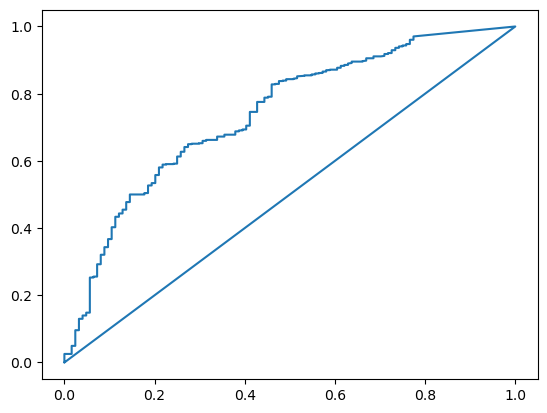

In [229]:
plt.plot(roc_curves[1][0], roc_curves[1][1])

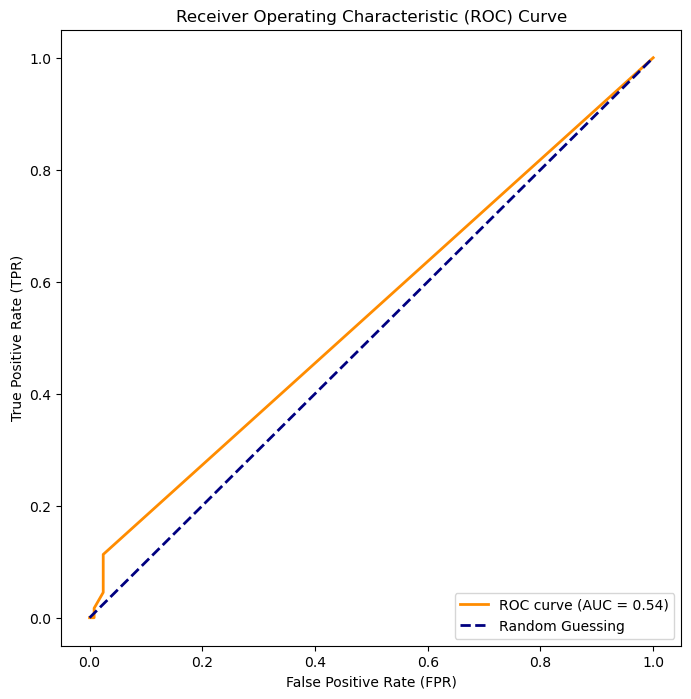

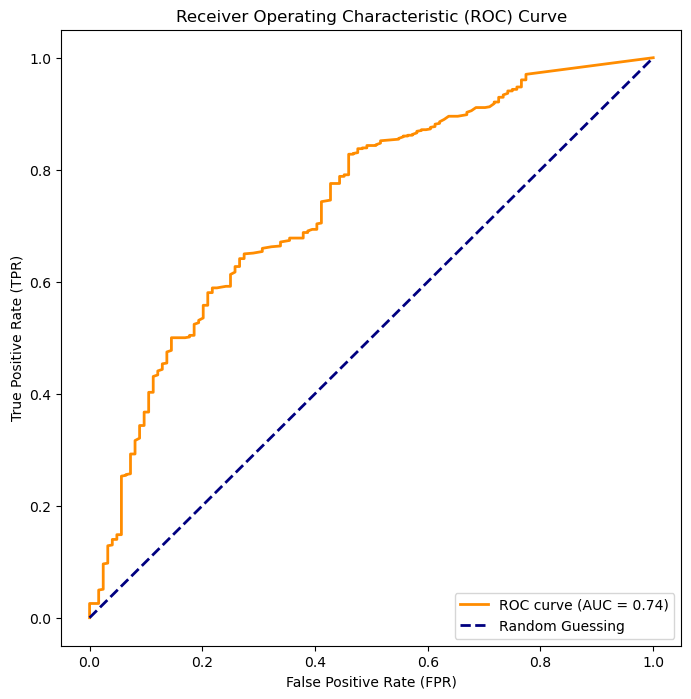

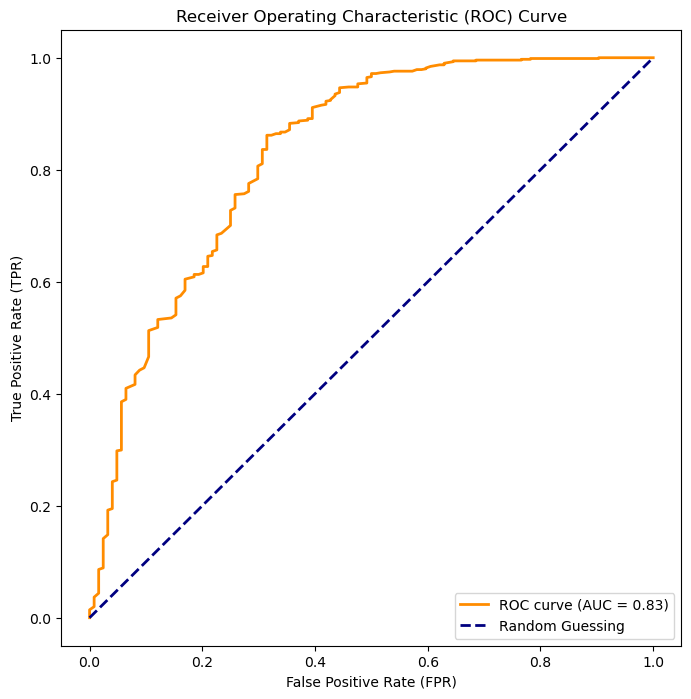

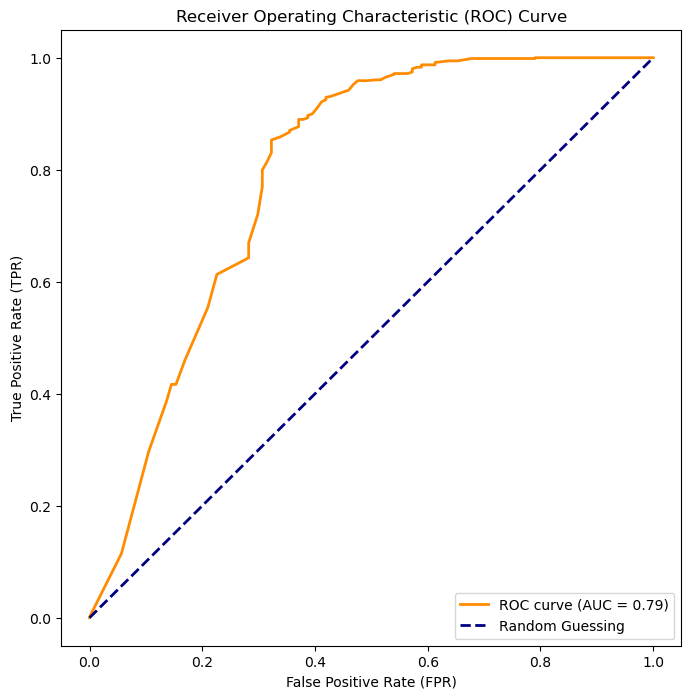

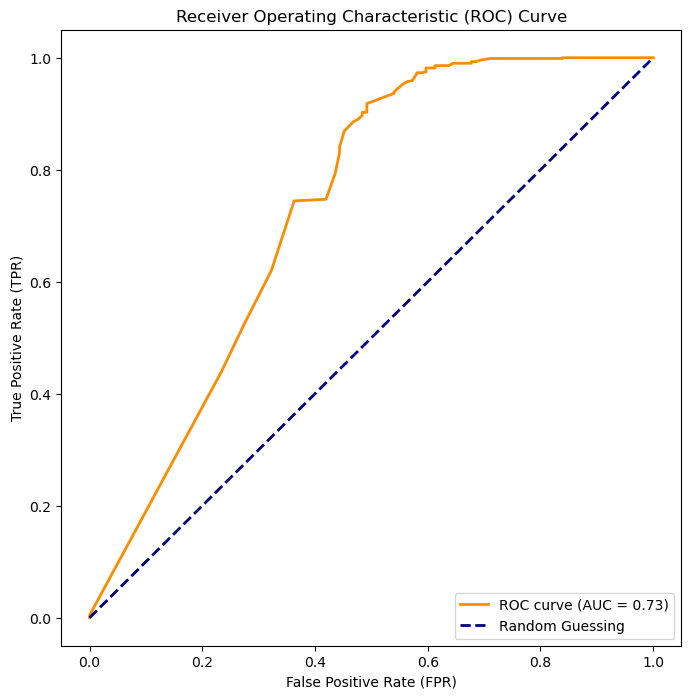

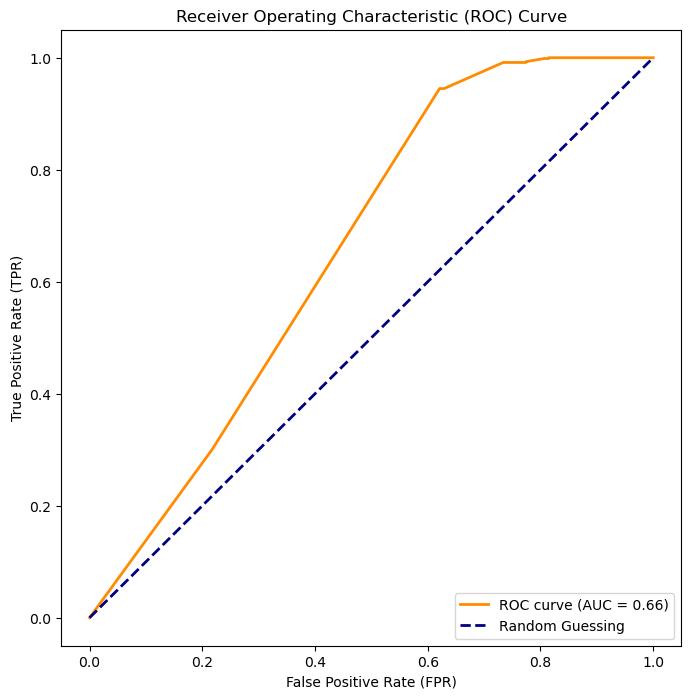

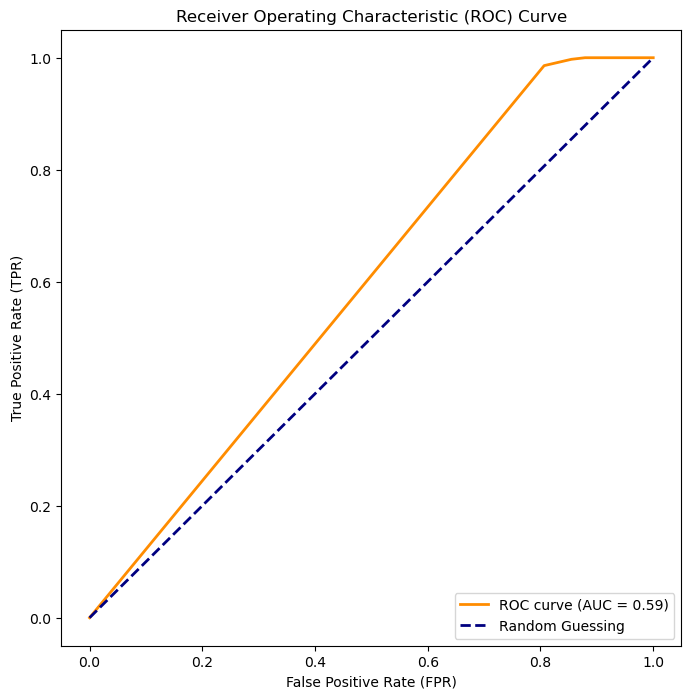

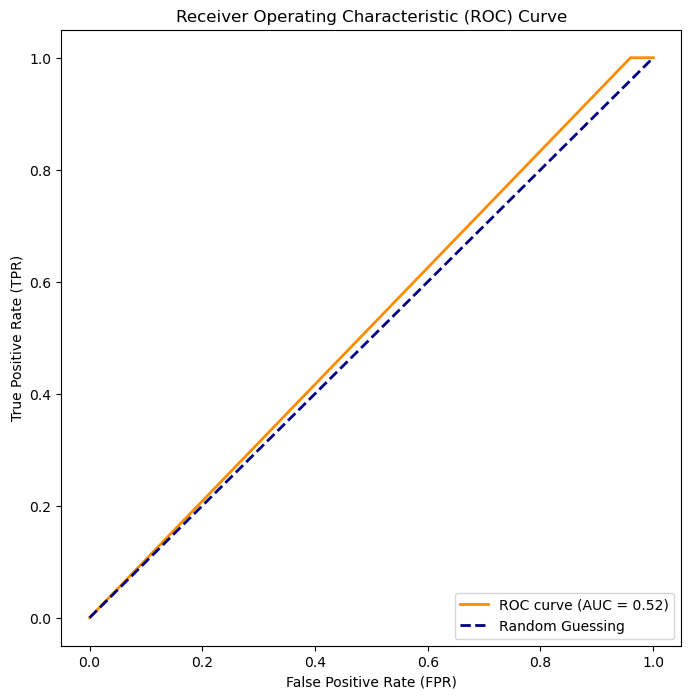

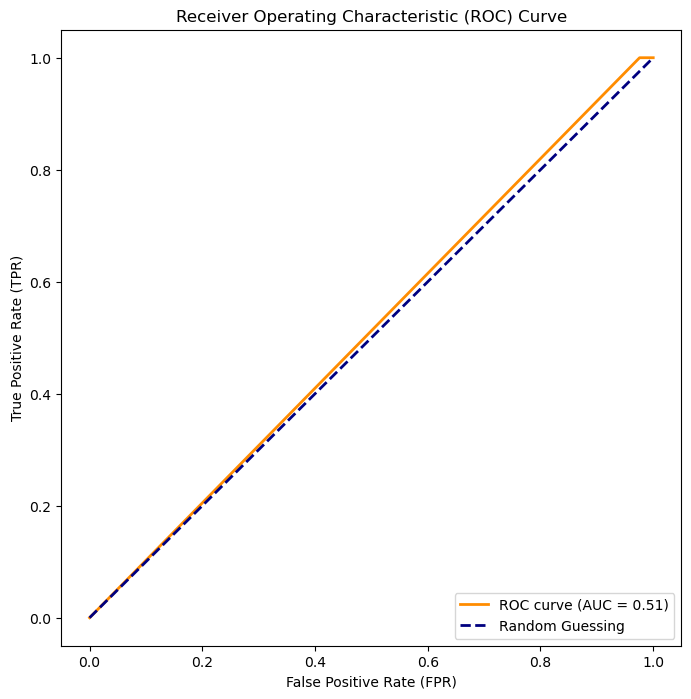

In [228]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

for i in range(1,10):
    data_for_r = total_scores[i-1]

    score = data_for_r[:,1]
    label = data_for_r[:,0]

    # Sort scores and corresponding labels
    sorted_indices = np.argsort(score)
    sorted_score = score[sorted_indices]
    # normalize the score from 0 to 1

    sorted_score = (sorted_score - sorted_score.min()) / (sorted_score.max() - sorted_score.min())
    sorted_label = label[sorted_indices]

    # Initialize variables
    tprs = []
    fprs = []

    # Iterate through each score as a threshold
    for threshold in np.arange(0, 1.01, 0.0001):

        # Compute true positive rate (tpr) and false positive rate (fpr)
        tp = np.sum((sorted_score >= threshold) & (sorted_label == 1))
        fp = np.sum((sorted_score >= threshold) & (sorted_label == 0))
        fn = np.sum((sorted_score < threshold) & (sorted_label == 1))
        tn = np.sum((sorted_score < threshold) & (sorted_label == 0))

        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)

        tprs.append(tpr)
        fprs.append(fpr)

    # Calculate AUC
    roc_auc = auc(fprs, tprs)

    # Plot ROC curve
    plt.figure(figsize=(8, 8))
    plt.plot(fprs, tprs, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()